In [0]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

In [0]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
backend.set_session(sess)

In [0]:
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"


sample_image_path = "https://images.saatchiart.com/saatchi/951100/art/3677343/2747228-XPQWPOTV-6.jpg"
waves_image_path = "https://images.theconversation.com/files/141932/original/image-20161017-14847-1a7gm58.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=496&fit=clip"

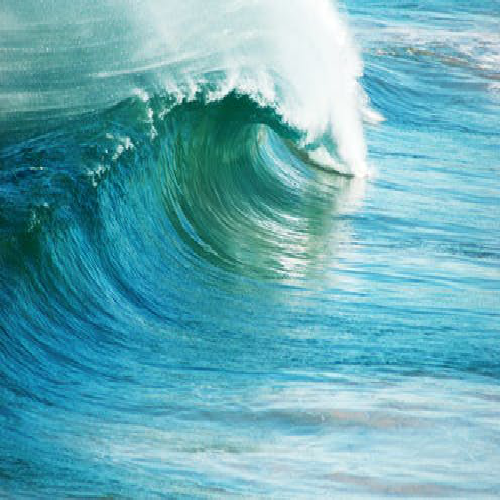

In [0]:
input_image = Image.open(BytesIO(requests.get(waves_image_path).content))
input_image = input_image.resize((500, 500))
input_image.save(input_image_path)
input_image

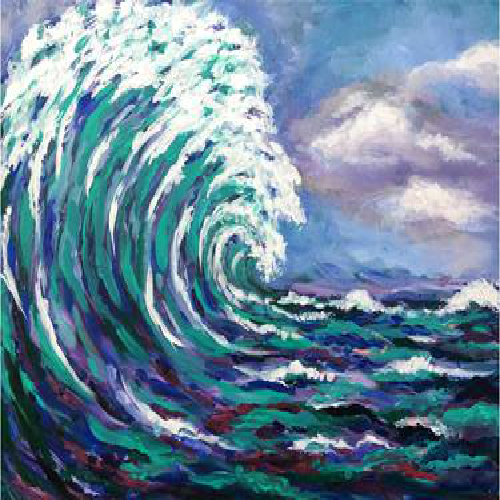

In [0]:
style_image = Image.open(BytesIO(requests.get(sample_image_path).content))
style_image = style_image.resize((500, 500))
style_image.save(style_image_path)
style_image

In [0]:
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]

In [0]:
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]
input_image_array.shape

(1, 500, 500, 3)

In [0]:
style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

In [0]:
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, 500, 500, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += 0.02 * content_loss(content_image_features, combination_features)

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = 500 * 500
    return backend.sum(backend.square(style - combination)) / (4. * (3 ** 2) * (size ** 2)) # 3 is no. of channels

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (4.5 / len(style_layers)) * style_loss

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :499, :499, :] - x[:, 1:, :499, :])
    b = backend.square(x[:, :499, :499, :] - x[:, :499, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))  # TOTAL_VARIATION_LOSS_FACTOR = 1.25

loss += 0.995 * total_variation_loss(combination_image) # TOTAL_VARIATION_WEIGHT = 0.995

In [0]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, 500, 500, 3))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
x = np.random.uniform(0, 255, (1, 500, 500, 3)) - 128.

for i in range(25):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    

Iteration 0 completed with loss 58996101120
Iteration 1 completed with loss 33456254976
Iteration 2 completed with loss 25597298688
Iteration 3 completed with loss 21685420032
Iteration 4 completed with loss 19431612416
Iteration 5 completed with loss 18047946752
Iteration 6 completed with loss 17049038848
Iteration 7 completed with loss 16204754944
Iteration 8 completed with loss 15642343424
Iteration 9 completed with loss 15203204096
Iteration 10 completed with loss 14905525248
Iteration 11 completed with loss 14674164736
Iteration 12 completed with loss 14517836800
Iteration 13 completed with loss 14374672384
Iteration 14 completed with loss 14277810176
Iteration 15 completed with loss 14221624320
Iteration 16 completed with loss 14162157568
Iteration 17 completed with loss 14117690368
Iteration 18 completed with loss 14081059840
Iteration 19 completed with loss 14050362368
Iteration 20 completed with loss 14025524224
Iteration 21 completed with loss 14003703808
Iteration 22 complet

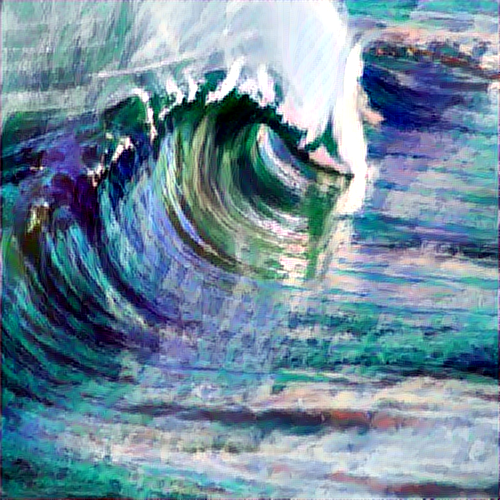

In [0]:
x = x.reshape((500, 500, 3))
x = x[:, :, ::-1]
x[:, :, 0] = np.add(x[:, :, 0], IMAGENET_MEAN_RGB_VALUES[2], out=x[:, :, 0], casting="unsafe")
x[:, :, 1] = np.add(x[:, :, 1], IMAGENET_MEAN_RGB_VALUES[1], out=x[:, :, 1], casting="unsafe")
x[:, :, 2] = np.add(x[:, :, 2], IMAGENET_MEAN_RGB_VALUES[0], out=x[:, :, 2], casting="unsafe")
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

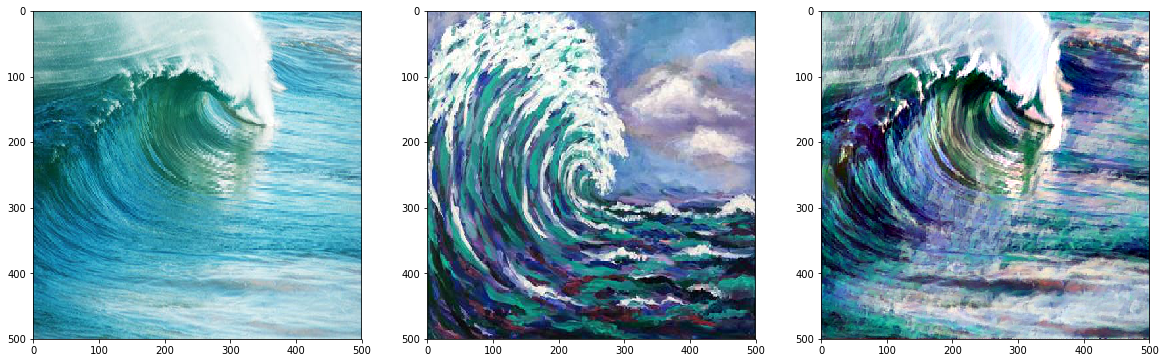

In [0]:
img = mpimg.imread(input_image_path)

pl = plt.figure(figsize=(20,30))
ax = pl.add_subplot(3,3,1)
ax.imshow(img)

img = mpimg.imread(style_image_path)


ax = pl.add_subplot(3,3,2)
ax.imshow(img)

img = mpimg.imread(output_image_path)


ax = pl.add_subplot(3,3,3)
ax.imshow(img)
plt.show()